# **Installing dependencies**

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import keras as keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras import Input
from keras.utils import plot_model
from keras import layers
from keras.preprocessing.image import load_img
from keras.models import Sequential, load_model
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import shutil

In [2]:
base_dir = "images/"
dirs = os.listdir(base_dir)

for dir in dirs:
    class_path = os.path.join(base_dir, dir)
    if os.path.isdir(class_path):
        files = os.listdir(class_path)
        print(f"{dir} Folder has {len(files)} images")

Cigar-shaped smooth Folder has 5917 images
completely round smooth Folder has 6096 images
spiral Folder has 5641 images
In between smooth Folder has 5831 images
edge-on Folder has 2821 images


In [3]:
imgSize = 250
batch = 32

# **Creating a test dataset**


In [4]:
'''
src_dir = "images"
dst_dir = "images_test"
test_ratio = 0.15
random.seed(42)

for class_name in os.listdir(src_dir):
    src_class_dir = os.path.join(src_dir, class_name)
    dst_class_dir = os.path.join(dst_dir, class_name)
    os.makedirs(dst_class_dir, exist_ok=True)

    all_imgs = os.listdir(src_class_dir)
    random.shuffle(all_imgs)

    n_test = int(len(all_imgs) * test_ratio)
    test_imgs = all_imgs[:n_test]

    for img in test_imgs:
        src_path = os.path.join(src_class_dir, img)
        dst_path = os.path.join(dst_class_dir, img)
        shutil.move(src_path, dst_path)

print("Moved test images to:", dst_dir)'''


'\nsrc_dir = "images"\ndst_dir = "images_test"\ntest_ratio = 0.15\nrandom.seed(42)\n\nfor class_name in os.listdir(src_dir):\n    src_class_dir = os.path.join(src_dir, class_name)\n    dst_class_dir = os.path.join(dst_dir, class_name)\n    os.makedirs(dst_class_dir, exist_ok=True)\n\n    all_imgs = os.listdir(src_class_dir)\n    random.shuffle(all_imgs)\n\n    n_test = int(len(all_imgs) * test_ratio)\n    test_imgs = all_imgs[:n_test]\n\n    for img in test_imgs:\n        src_path = os.path.join(src_class_dir, img)\n        dst_path = os.path.join(dst_class_dir, img)\n        shutil.move(src_path, dst_path)\n\nprint("Moved test images to:", dst_dir)'

# **Training/Validation/Test split**

In [5]:
train_ds, valid_ds = image_dataset_from_directory(base_dir,
                                                  seed = 42,
                                                  validation_split=0.2,
                                                  subset = "both",
                                                  batch_size = batch,
                                                  image_size = (imgSize, imgSize))
test_ds = image_dataset_from_directory(
    "images_test2",
    image_size=(imgSize, imgSize),
    batch_size=batch,
    shuffle=False
)

Found 26306 files belonging to 5 classes.
Using 21045 files for training.
Using 5261 files for validation.


2025-07-17 05:50:26.253129: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-17 05:50:26.253352: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-17 05:50:26.253357: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-17 05:50:26.253729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-17 05:50:26.253936: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 4639 files belonging to 5 classes.


In [6]:
galaxyTypes = train_ds.class_names
galaxyTypes

['Cigar-shaped smooth',
 'In between smooth',
 'completely round smooth',
 'edge-on',
 'spiral']

# **Viewing sample images**

2025-07-17 05:50:31.957336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


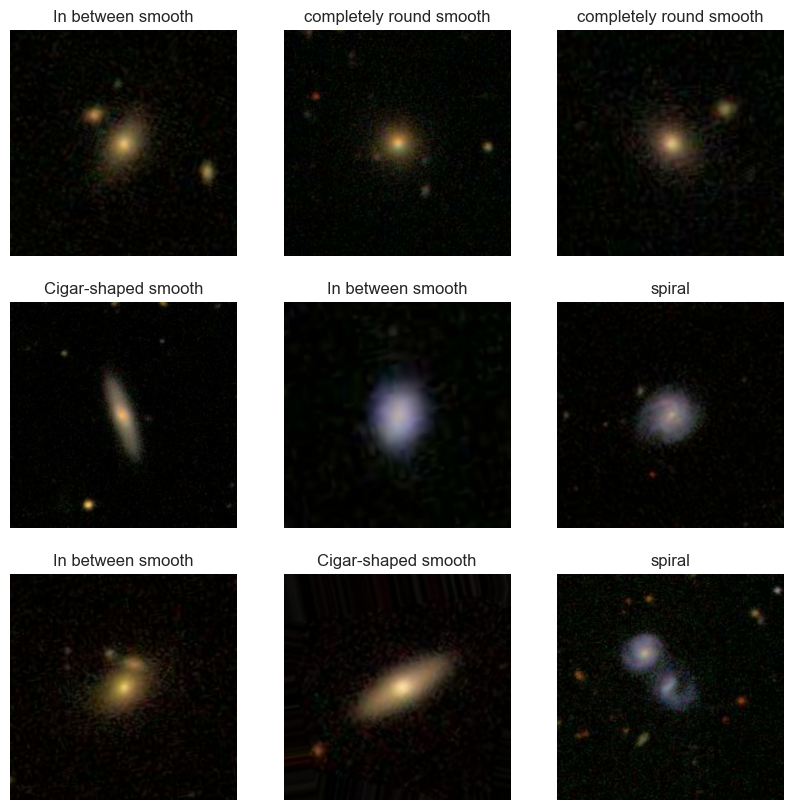

In [7]:
i = 0
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8")) #Tensors can't be displayed directly so convert to numpy first, and convert                                              float32 to uint8 for imshow()
        plt.title(galaxyTypes[labels[i]])
        plt.axis("off")

# **Optimizing Data Pipeline**


In [8]:
autotune = tf.data.AUTOTUNE

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=autotune)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size = autotune)

# **Data Augmentation**

In [11]:
#Data augmentation submodel, using keras functional API layers, can be added to the model later so it augments data on-the-fly using GPU, no need to store augmented images
dataAugmentation = Sequential([
    Input(shape=(imgSize, imgSize, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

2025-07-17 05:50:49.596757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:22: Filling up shuffle buffer (this may take a while): 399 of 1000
2025-07-17 05:50:59.581141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-07-17 05:51:06.932626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


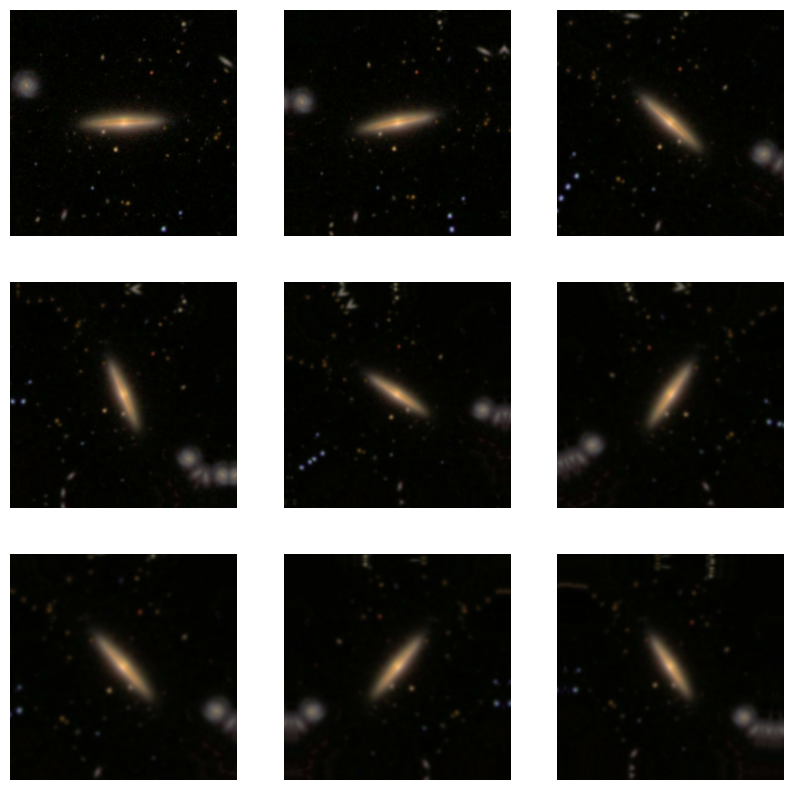

In [12]:
i = 0
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
      images = dataAugmentation(images)
      plt.subplot(3, 3, i + 1)
      plt.imshow(images[0].numpy().astype("uint8"))
      plt.axis("off")

# **Creating the Model: Model 1**

In [13]:
model = Sequential([
    dataAugmentation,
    #Data normalization
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    #added another conv block
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),

    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(galaxyTypes))
])

In [14]:
model.compile(optimizer='adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), #applies softmax internally, numerically more stable
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 250, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 250, 250, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 125, 125, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,784,613 (14.44 MB)

 Trainable params: 3,784,613 (14.44 MB)

 Non-trainable params: 0 (0.00 B)

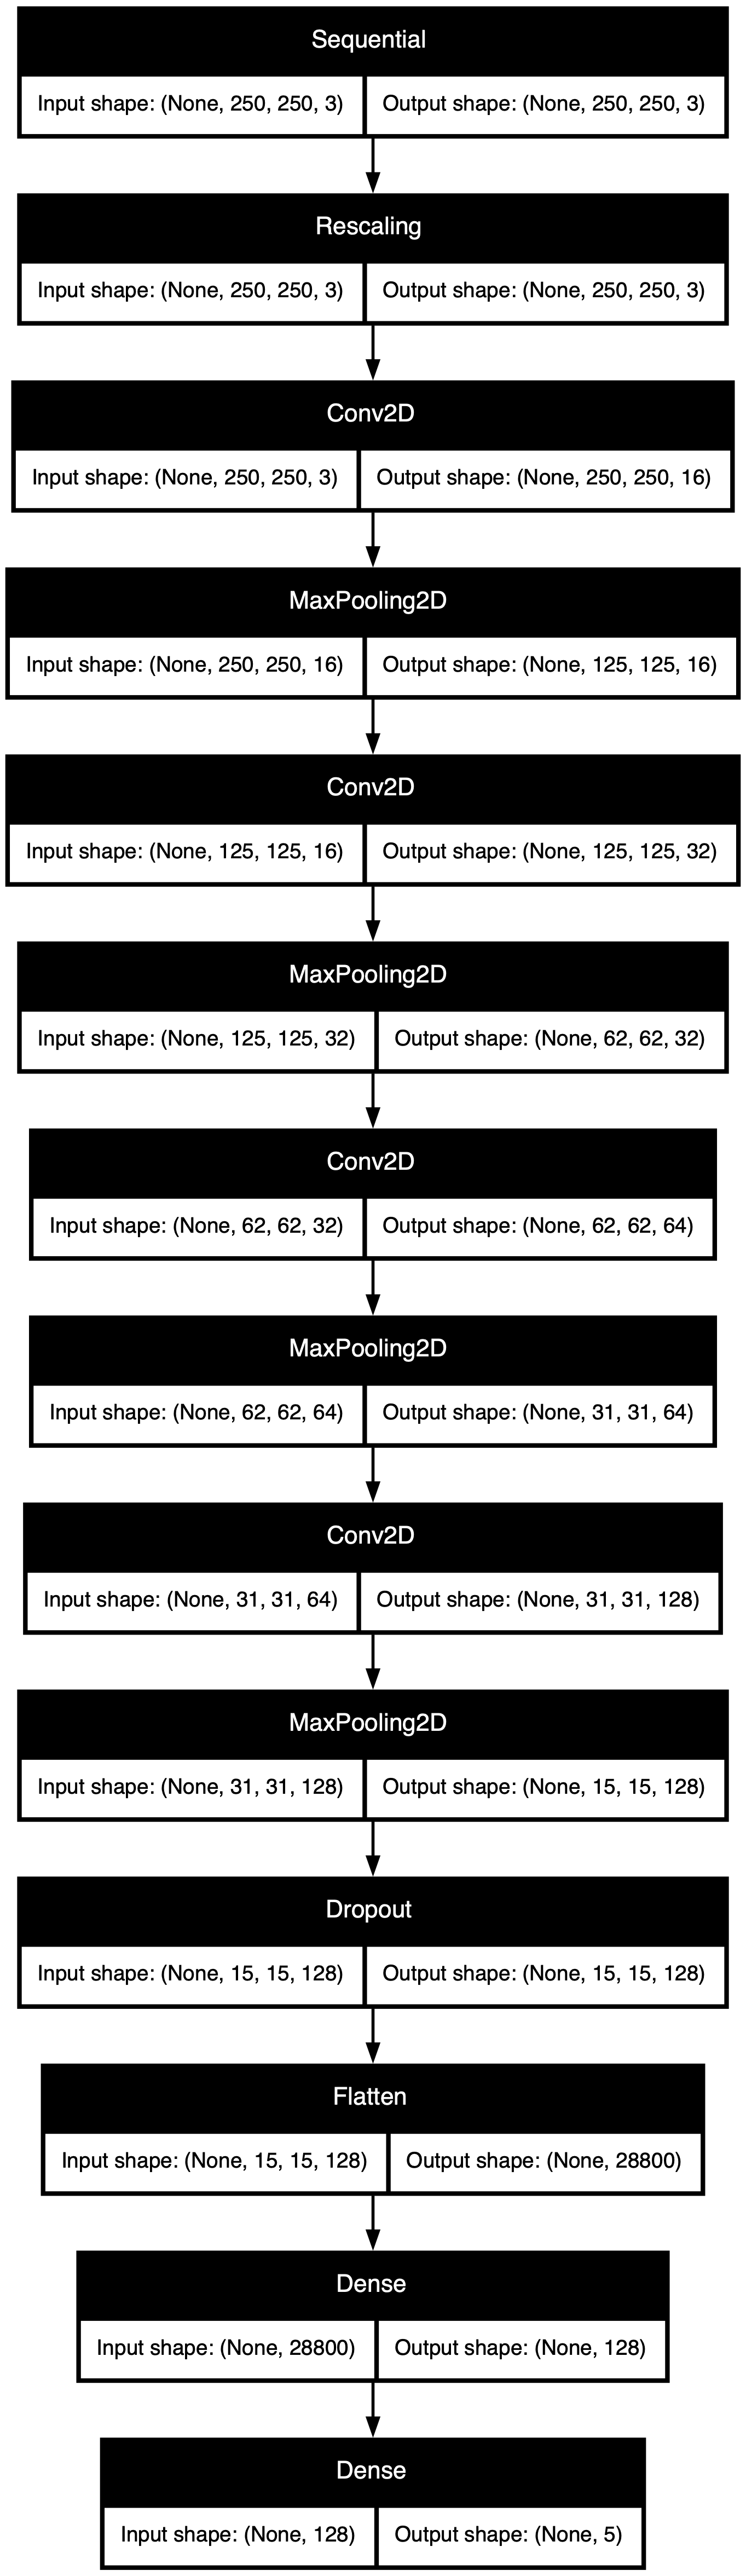

In [16]:
plot_model(model, show_shapes=True) #plot_model for visualization

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [18]:
his = model.fit(train_ds, epochs=15, validation_data=valid_ds, callbacks=[early_stop])

Epoch 1/15


2025-07-17 05:51:36.306238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-07-17 05:51:36.315147: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5739 - loss: 1.0031

2025-07-17 05:53:54.106278: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


658/658 ━━━━━━━━━━━━━━━━━━━━ 156s 235ms/step - accuracy: 0.5741 - loss: 1.0027 - val_accuracy: 0.8002 - val_loss: 0.5114
Epoch 2/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 172s 259ms/step - accuracy: 0.8215 - loss: 0.4674 - val_accuracy: 0.8806 - val_loss: 0.3400
Epoch 3/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 159s 239ms/step - accuracy: 0.8632 - loss: 0.3663 - val_accuracy: 0.8679 - val_loss: 0.3354
Epoch 4/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 190s 286ms/step - accuracy: 0.8819 - loss: 0.3171 - val_accuracy: 0.9122 - val_loss: 0.2652
Epoch 5/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 187s 281ms/step - accuracy: 0.9017 - loss: 0.2609 - val_accuracy: 0.9141 - val_loss: 0.2358
Epoch 6/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 181s 273ms/step - accuracy: 0.9063 - loss: 0.2430 - val_accuracy: 0.9036 - val_loss: 0.2480
Epoch 7/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 206s 310ms/step - accuracy: 0.9138 - loss: 0.2369 - val_accuracy: 0.9264 - val_loss: 0.1971
Epoch 8/15
658/658 ━━━━━━━━━━━━━━━━━━━━ 199s 298ms/step - accuracy: 0.9187 - loss: 0.21

# **Evaluation**

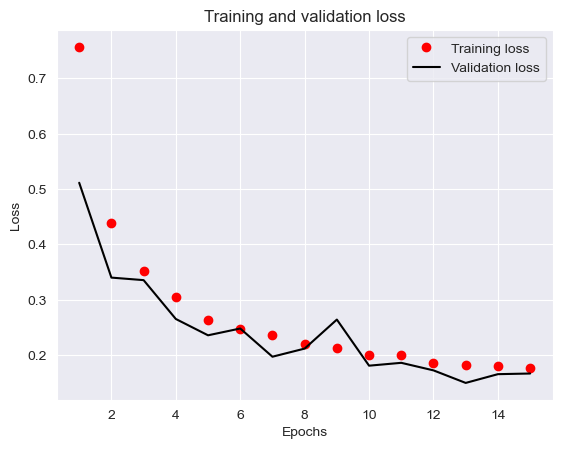

In [19]:
history_dict =  his.history

import matplotlib.pyplot as plt
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'k-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

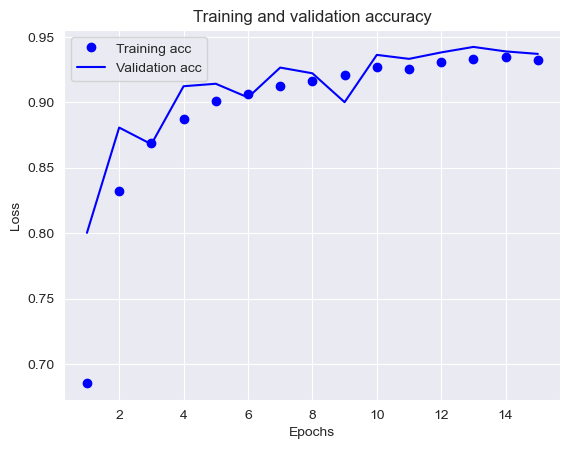

In [20]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

145/145 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9214 - loss: 0.1911
Test Accuracy: 0.9417977929115295


# **Precision/Recall/F1-Score & Confusion Matrix**

In [22]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.numpy())

print(classification_report(y_true, y_pred, target_names=galaxyTypes))

2025-07-17 06:42:14.925859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━

2025-07-17 06:42:31.136592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


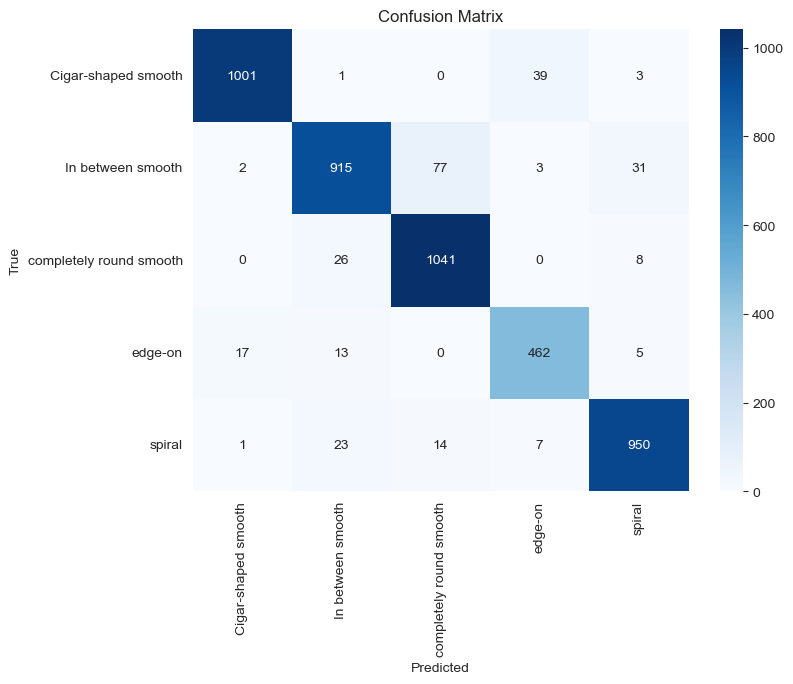

In [23]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=galaxyTypes, yticklabels=galaxyTypes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# **Testing Samples**

In [27]:
def classify_images(image_path):
    input_image = keras.utils.load_img(image_path, target_size=(250, 250))
    input_img_arr = keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_img_arr, 0)
    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = "The image belongs to " + galaxyTypes[np.argmax(result)] + " galaxy" + " with a score of " + str(np.max(result)*100)
    return outcome

In [52]:
classify_images("samples/sample2.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


'The image belongs to spiral galaxy with a score of 99.98255372047424'